### Causal inference for time series models
---------------------------------------------

Comparative analysis of brent, causal impact and causality Python modules.

##### Granger causality:

"If $\sigma^2(X|U) < \sigma^2(X|\overline{U - Y})$, we say that $Y$ is causing $X$, denoted by $Y_t => X_t$. We say that $Y_t$ is causing $X_t$ if we are better able to predict $X_t$ using all available information than if the information apart from $Y_t$ had been used." (Econometrica, Vol. 37, No. 3. (Aug., 1969), p. 428)

### Load and prepare the data

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [4]:
country = 'United States'

In [5]:
country_labels = ['Brazil', 'China', 'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japan', 'Netherlands',
                  'Senegal', 'Singapore', 'Switzerland', 'United States']

In [6]:
assert country in country_labels

#### Load and combine the features and labels

In [7]:
features_df = pd.read_csv('features/m_one/world_aggregate.csv', sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [8]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [9]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.2673,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.0517,0.0000,0.0000,0.0000,0.0019,45.3268,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.0518,0.0000,0.0000,0.0000,0.0019,45.3863,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.0519,0.0000,0.0000,0.0000,0.0019,45.4458,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.0520,0.0000,0.0000,0.0000,0.0019,45.5052,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


In [10]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'unemployed', 'urban population', 'workers', 'Brazil', 'China',
       'Colombia', 'France', 'Ghana', 'India', 'Indonesia', 'Japa

#### Prepare the country features

In [11]:
base_feature_df = combined_df[['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'unemployed', 'urban population', 'workers', country]]

In [12]:
base_feature_df.to_csv('features/ci/combined_%s.csv' % country.lower(), sep=',', index=False)

In [13]:
base_feature_df['cpi'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);

In [14]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

In [15]:
base_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'unemployed', 'urban population', 'workers', 'cpi'],
      dtype='object')

In [16]:
df = base_df[['date','bank nonperforming loans', 'energy imports', 'food exports',
       'inflation', 'lending interest rate', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings', 'household consumption expenditure',
       'listed companies', 'services trade', 'trade', 'government interest payments external debt',
       'government tax revenue', 'unemployed', 'workers', 'cpi']].set_index('date')

### Causal impact
-------------------

[Causal impact](https://github.com/tcassou/causal_impact) provides causal inference using Bayesian structural time-series models, so no pre-processing was required.

In [17]:
ci_df = df.rename(columns={'cpi': 'y'})

In [18]:
ci_df.index

Index(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01',
       '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
       ...
       '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
      dtype='object', name='date', length=696)

In [19]:
from causal_impact.causal_impact import CausalImpact

ci = CausalImpact(ci_df, '2008-10-01')
print('Plot impact of global financial crisis on consumer price indices in %s.' % country)

Plot impact of global financial crisis on consumer price indices in United States.


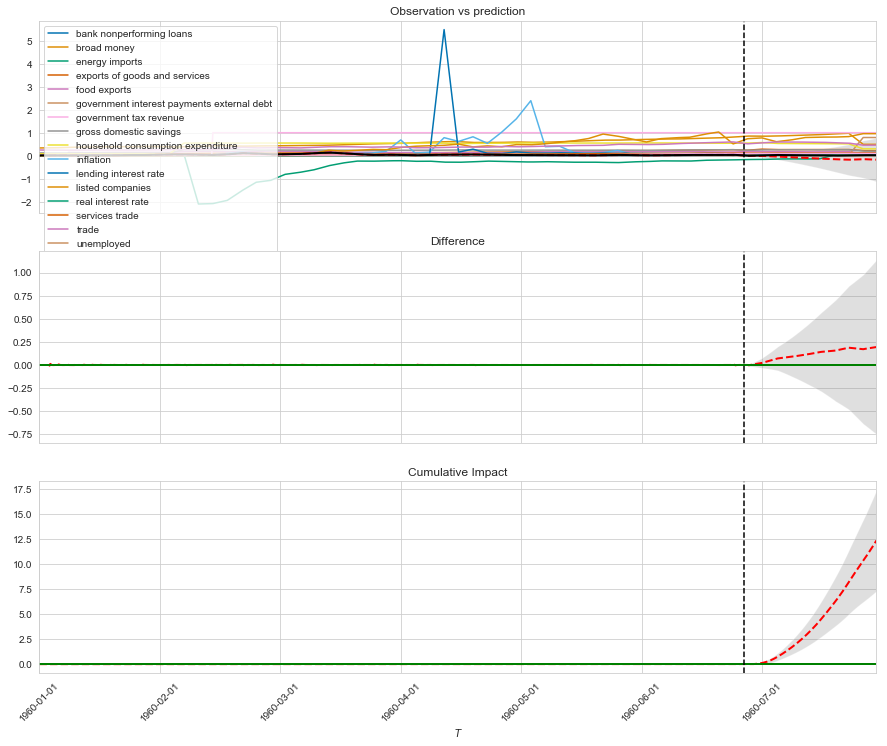

In [20]:
ci.run()
ci.plot()

### Causality
--------------

[Causality](https://github.com/akelleh/causality) is a module for causal effect estimation.

In [21]:
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

ic_algo = IC(RobustRegressionTest)
variable_types = { c: 'c' for c in list(df.columns.values)}
graph = ic_algo.search(df, variable_types)
graph.edges(data=True)

EdgeDataView([('bank nonperforming loans', 'workers', {'marked': False, 'arrows': ['workers']}), ('food exports', 'gross domestic savings', {'marked': False, 'arrows': ['gross domestic savings']}), ('inflation', 'lending interest rate', {'marked': False, 'arrows': ['inflation']}), ('inflation', 'unemployed', {'marked': False, 'arrows': ['inflation', 'unemployed', 'unemployed']}), ('lending interest rate', 'government interest payments external debt', {'marked': False, 'arrows': []}), ('real interest rate', 'listed companies', {'marked': False, 'arrows': []}), ('real interest rate', 'unemployed', {'marked': False, 'arrows': ['unemployed', 'unemployed']}), ('broad money', 'exports of goods and services', {'marked': False, 'arrows': ['exports of goods and services']}), ('broad money', 'trade', {'marked': False, 'arrows': ['trade']}), ('exports of goods and services', 'trade', {'marked': False, 'arrows': ['exports of goods and services', 'exports of goods and services', 'trade']}), ('expor

In [22]:
true_edges = list(filter(lambda x: len(x) > 3, [str(edge) if 'True' in str(edge) else '' for edge in graph.edges(data=True)]))

In [23]:
true_edges

["('gross domestic savings', 'household consumption expenditure', {'marked': True, 'arrows': ['household consumption expenditure']})",
 "('household consumption expenditure', 'government tax revenue', {'marked': True, 'arrows': ['household consumption expenditure']})"]

### Brent
----------

Since [brent](https://github.com/koaning/brent) requires discretized variables, I've computed deltas over the timeseries to be able to apply the module - with {0, 1} as the binary expressions of decrease / no change vs. increase in the value.

In [24]:
df.columns

Index(['bank nonperforming loans', 'energy imports', 'food exports',
       'inflation', 'lending interest rate', 'real interest rate',
       'broad money', 'exports of goods and services',
       'gross domestic savings', 'household consumption expenditure',
       'listed companies', 'services trade', 'trade',
       'government interest payments external debt', 'government tax revenue',
       'unemployed', 'workers', 'cpi'],
      dtype='object')

In [25]:
diff_df = df.diff().iloc[1:]

In [26]:
for column in diff_df.columns:
    diff_df[column.replace(' ', '_')] = np.where(np.sign(diff_df[column]) == 1.0, 1.0, 0.0) 

In [27]:
brent_df = diff_df[list(map(lambda x: x.replace(' ', '_'), diff_df.columns))]

In [28]:
brent_df.describe()

,bank_nonperforming_loans,energy_imports,food_exports,inflation,lending_interest_rate,real_interest_rate,broad_money,exports_of_goods_and_services,gross_domestic_savings,household_consumption_expenditure,...,lending_interest_rate,real_interest_rate,broad_money,exports_of_goods_and_services,gross_domestic_savings,household_consumption_expenditure,listed_companies,services_trade,government_interest_payments_external_debt,government_tax_revenue
count,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,...,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000,695.0000
mean,0.1568,0.6734,0.4504,0.5885,0.5698,0.4849,0.7597,0.7942,0.5180,0.4317,...,0.5698,0.4849,0.7597,0.7942,0.5180,0.4317,0.5194,0.7597,0.3986,0.0014
std,0.3639,0.4693,0.4979,0.4925,0.4955,0.5001,0.4276,0.4045,0.5000,0.4957,...,0.4955,0.5001,0.4276,0.4045,0.5000,0.4957,0.5000,0.4276,0.4900,0.0379
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
50%,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,...,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
75%,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [29]:
selected_columns = ['broad_money', 'exports_of_goods_and_services', 'gross_domestic_savings', 'household_consumption_expenditure', 'government_tax_revenue', 'inflation', 'unemployed']

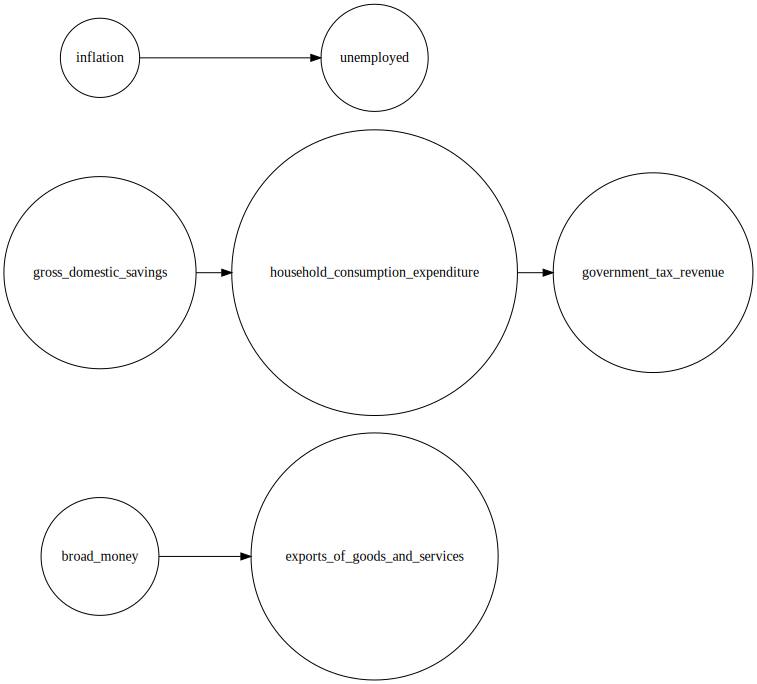

In [30]:
from brent import DAG, Query

dag = (DAG(dataframe=brent_df[selected_columns])\
       .add_edge('inflation', 'unemployed')\
       .add_edge('broad_money', 'exports_of_goods_and_services')\
       .add_edge('gross_domestic_savings', 'household_consumption_expenditure')\
       .add_edge('household_consumption_expenditure', 'government_tax_revenue'))
dag.plot()

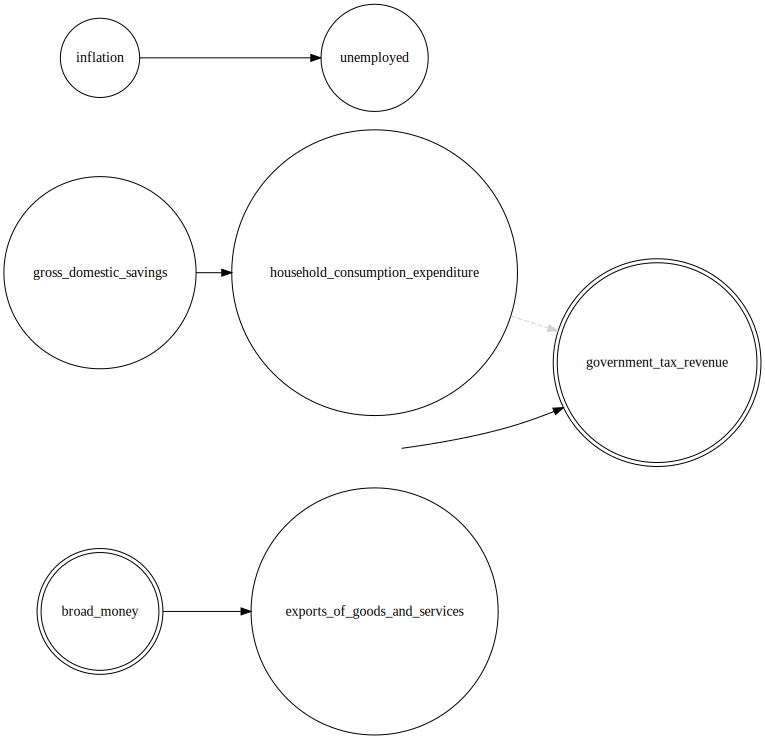

In [31]:
q = Query(dag).given(broad_money=1.0).do(government_tax_revenue=0.0)
q.plot()